In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import dask
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
from eofs.xarray import Eof
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import cut_regrid_reynolds_sst,cut_process_sst_obs_trends,proc_landschutzer,process_co2_land_trends

In [2]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.130:41785,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
syear='2000'# or '2000'
calculate_and_save_eofs=True
deseasonalise=True
yearName='_2000' #'' otherwise

In [4]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac
eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
eqpac=eqpac.sel(ensemble=26,time=slice(syear+'-01-01','2019-12-31'))
eqpac=eqpac.chunk(dict(time=-1))

/local/v45/np1383/tmp/ipykernel_3364937/1675290067.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


In [5]:
land_co2=(xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365).sel(lon=slice(120,290),lat=slice(-20,20),time=slice(syear+'-01-01','2019-12-31'))
rodenbeck_co2=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc').sel(lon=slice(120,290),lat=slice(-20,20),time=slice(syear+'-01-01','2019-12-31'))
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-20,20),time=slice(syear+'-01-01','2019-12-31'))

In [6]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360
phys['st_ocean']=phys['st_ocean']*-1
phys['sw_ocean']=phys['sw_ocean']*-1
phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=26)
phys_eqpac=phys_eqpac.chunk(dict(time=-1))

In [7]:
cluster

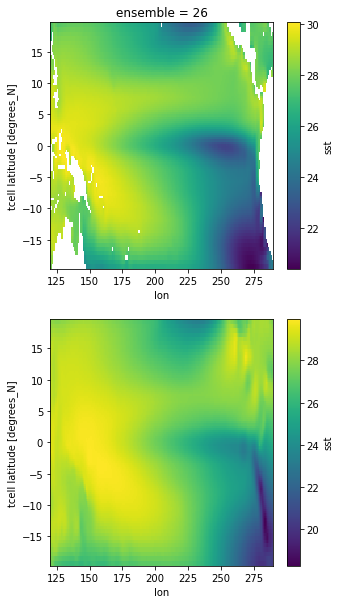

In [8]:
plt.figure(figsize=(5,10))
plt.subplot(211)
phys_eqpac.sst.mean(dim='time').plot()
plt.subplot(212)
rey_sst.sst.mean(dim='time').plot()

In [9]:

if calculate_and_save_eofs==True:
    co2_dat=(eqpac.stf10.interpolate_na(dim='time')/1000)*86400*-12
    if deseasonalise==True:
        co2_dat=co2_dat.rolling(time=12,center=True).mean()
    eqpac_co2_eof_solver=Eof(co2_dat)
    eqpac_co2_eof=eqpac_co2_eof_solver.eofs()
    #eqpac_co2_eof.sel(mode=1).plot()
    eqpac_co2_eof.to_netcdf('../external_data/cafe_co2_eofs'+yearName+'.nc')
    print('cafe co2 eofs saved')
    
    sst_dat=phys_eqpac.sst.interpolate_na(dim='time')
    if deseasonalise==True:
        sst_dat=co2_dat.rolling(time=12,center=True).mean()
    eqpac_sst_eof_solver=Eof(sst_dat)
    eqpac_sst_eof=eqpac_sst_eof_solver.eofs()
    eqpac_sst_eof.to_netcdf('../external_data/cafe_sst_eofs'+yearName+'.nc')
    print('cafe sst eofs saved')
    cluster.scale(cores=2)

ValueError: error encountered in SVD, check that missing values are in the same places at each time and that all the values are not missing

In [ ]:
eqpac_sst_eof=xr.open_dataset('../external_data/cafe_sst_eofs'+yearName+'.nc')
eqpac_co2_eof=xr.open_dataset('../external_data/cafe_co2_eofs'+yearName+'.nc')

In [ ]:
#cluster.scale(2)

In [ ]:
pwd

In [ ]:
# Calculate reynolds eofs on the fly as they are pretty lightweight
rey_eof_solver=Eof(rey_sst.sst)
rey_eof=rey_eof_solver.eofs()

In [ ]:
# Same for Landschutzer CO2 fluxes
co2_flux_eof=Eof(land_co2.fgco2_smoothed)
land_eof=co2_flux_eof.eofs()

In [ ]:
#cluster.scale(2)
co2_flux_eof.eofsAsCorrelation(neofs=4)

In [ ]:
modes=[0,1,2,3,4,5,6,7,8,9,10]
for mode in modes:

    plt.figure(figsize=(15,10))
    plt.subplot(221)
    rey_eof.sel(mode=mode).plot()
    plt.title('OBS, Reynolds OISST 2000-2020'+str(mode))
    plt.subplot(222)
    eqpac_sst_eof.eofs.sel(mode=mode).plot()
    plt.title('CAFE60, SST 2000-2020, mode: '+str(mode))
    plt.subplot(223)
    land_eof.sel(mode=mode).plot()
    plt.title('OBS, Landschutzer CO2 Flux *-1 2000-2020'+str(mode))
    plt.subplot(224)
    eqpac_co2_eof.eofs.sel(mode=mode).plot()
    plt.title('CAFE60, CO2 flux')
    plt.show()

In [ ]:
key_drivers=['paco2','stf10','pprod_gross_2d','surface_alk']#pco2#
key_drivers_phys=['sst','salt']

vars_of_interest=eqpac[key_drivers]
vars_of_interest[key_drivers_phys]=phys_eqpac[key_drivers_phys]

In [ ]:
#eqpac_use=eqpac.stf10.chunk(dict(time=-1)).sel(ensemble=26)
#eqpac_use=eqpac_use.interpolate_na(dim='time')#,dask_gufunc_kwargs={'allow_rechunk':True})
#eqpac_use=xr.open_dataset('../processed_data/eof_eqpac_test.nc')